In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% }</style>"))

In [2]:
import numpy as np
import pandas as pd 
from scipy.spatial.distance import pdist, squareform, cdist
#from readtraj import read_traj,sort_traj
import math
from tqdm.notebook import tqdm
from modulefile import chunk_traj, read_sorted
pd.options.mode.chained_assignment = None
import os

In [3]:
import matplotlib.pyplot as plt

The pair distribution function g(r) is more simply thought of as the number of atoms a distance 'r' from a given atom divided by the
number at the same distance in an ideal gas at the same density.

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
# This will calculate the trajectory of com's
mass = {"C": 12, "H": 1, "N": 14}
molecules = ["N","H"] # Enter only the unique atoms of the molecule. # think if first value can be H
length_mol = 4
def do_com(trajectory, masses=mass, total_atoms=256, molecules=molecules, mol_length=length_mol):
    """
    This function calculates an center of mass trajectory for the specified molecules from the sorted trajectory. The returned dictionary containing COMs should usually be used as an input to the RDF code. 
    """
    assert molecules[0] != "H" ,"First atom should be heavy and not H"
    com_traj = {}
    for key in tqdm(trajectory.keys()):
        df = trajectory[key] # Current frame under consideration  
        heavy_atom_df = df.loc[(df['atoms'] == molecules[0])] # Dataframe of heavy atoms corresponding to 1st position in molecule list
        repeat_count = df.pivot_table(index=['mols'], aggfunc='size') # How many times each entry in mols columns is repeated i.e. effectively the length of the molecule 
        repeat_count = (repeat_count.mask(repeat_count != mol_length)).dropna() # If the length of the molecule is not as specified in the functions argument then drop them. 
        mol_df = df.loc[(df['mols'].isin(heavy_atom_df['mols'])) & (df['mols'].isin(repeat_count.index))] # Dataframe containing the molecules having the specified heavy atom and corresponding to the specified length
        #! total_unique_atoms = mol_df.atoms.nunique(dropna = True) # Total number of unique atoms in your mol_df
        #! unique_atoms = mol_df.atoms.unique() # List of unique atoms in your mol_df
        mol_df['mass'] = mol_df['atoms'].map(masses) # Map the masses to respective atoms as given in specified mass dictionary (input)
        assert (not mol_df['mass'].isnull().any()), "Some of the masses have not been assigned which means your mass dictinary is incomplete. Please provide mass list of all unique atoms in the trajectory." 
        #### Here first multiply by mass column and then do the following. 
        mol_df[['x','y','z']] = mol_df[['x','y','z']].mul(mol_df['mass'], axis=0) #  Multiplying by the masses 
        com_df = mol_df.groupby("mols").sum() # Numerator of the COM formula i.e x1*m1 + x2*m2 + x3*m3..... and same along y and z for every molecule. 
        com_df[['x','y','z']]  = com_df[['x','y','z']].div(com_df['mass'], axis=0) # Dividing by the total mass to get x_cm, y_cm and z_cm
        com_traj[key] = com_df # Storing the frame in dictionary or trajectory of center of masses.
        #print(mol_df)
        #break
    return com_traj

In [ ]:
molecules = ["N","H"]
def do_atom(trajectory, molecules=molecules):
    com_traj = {}
    for key in tqdm(trajectory.keys()):
        df = trajectory[key]
        heavy_atom_df = df.loc[(df['atoms'] == molecules[0])]
        com_traj[key] = heavy_atom_df
    return com_traj

In [4]:
def xyz_writer(input_traj, atoms=None, xyzname="output.xyz", com_traj=False):
    if os.path.exists(xyzname):
        os.remove(xyzname)
    if atoms is None:
        listdfs = list(input_traj.values())
        atoms = len(listdfs[0])
    if com_traj:
        atom_array = np.array(["A"]*atoms)
    else:
        atom_array = listdfs[0]['atoms'].to_numpy()
    str_array = np.zeros(atom_array.size, dtype=[('var1', 'U6'), ('var2', np.float64), ('var3', np.float64), ('var4', np.float64)])
    with open(xyzname, 'a') as file:    
        for counter, key in enumerate(tqdm(input_traj)):
            df = input_traj[key]
            file.write("{}\n".format(atoms))
            file.write("time = {}\n".format(counter))
            str_array['var1'] = atom_array
            str_array['var2'] = df['x'].to_numpy()
            str_array['var3'] = df['y'].to_numpy()
            str_array['var4'] = df['z'].to_numpy()
            np.savetxt(file, str_array, fmt='%5s %17.10f %17.10f %17.10f')
            #if counter==2:
            #    break
    return None

nn_traj = do_atom()
nnrdf = do_rdf(nn_traj, nbins=500)
a, b = nnrdf
np.savetxt("PBE-D3/90K-AA/90K_N-N_rdf.txt",np.c_[b,a],fmt="%15.8f")
plt.plot(b, a)

nn_traj_30k = do_atom(trajectory=sorted_trajectory_30k)
rdf_30k = do_rdf(nn_traj_30k, nbins=500)
g, rm = rdf_30k
plt.plot(rm, g)
np.savetxt("PBE-D3/30K-AA/30K_N-N_rdf.txt",np.c_[rm,g],fmt="%15.8f")

In [5]:
def make_whole(sorted_traj, atoms=256, x=18.284, y=12.740, z=11.778, write_traj=False):
    x_half = x/2.0
    y_half = y/2.0
    z_half = z/2.0
    output = {}
    for counter, key in enumerate(tqdm(sorted_traj)):
        df = sorted_traj[key]
        wholed_df = df.copy(deep=True)
        select_df = df[['index', 'x', 'y', 'z']]
        grouped_first_entry = df.groupby("mols").nth(0)
        repeat_count = df.groupby("mols").size()
        ref_df = grouped_first_entry.loc[grouped_first_entry.index.repeat(repeat_count)].reset_index(drop=True)
        ref_df = ref_df[['index', 'x', 'y', 'z']]
        r_ix = select_df - ref_df
        conditions_x, values_x = [(r_ix['x'] > x_half), (r_ix['x'] < -x_half)], [-x, x]
        conditions_y, values_y = [(r_ix['y'] > y_half), (r_ix['y'] < -y_half)], [-y, y]
        conditions_z, values_z = [(r_ix['z'] > z_half), (r_ix['z'] < -z_half)], [-z, z]
        shifts_x = np.select(conditions_x, values_x, default=0.0)
        shifts_y = np.select(conditions_y, values_y, default=0.0)
        shifts_z = np.select(conditions_z, values_z, default=0.0)
        wholed_df['x'] =  df['x'] + shifts_x
        wholed_df['y'] =  df['y'] + shifts_y
        wholed_df['z'] =  df['z'] + shifts_z
        output[key] = wholed_df
    if write_traj:
        xyz_writer(output, xyzname="wholed_traj.xyz")
        return None
    return output

In [ ]:
def do_rdf(traj_dict, nbins=100, x=18.284, y=12.740, z=11.778, rmax=None):
    h = np.zeros(nbins)
    box = np.array([x,y,z])
    if rmax is None:
        rmax = min(box) / 2.0
        #rmax = np.linalg.norm(box/2)
    dr = rmax / nbins
    #print(rmax, dr)
    periodic_dist  = lambda u, v: np.linalg.norm((u-v) - (box * ((u-v)/box).round()))
    for counter, key in enumerate(tqdm((traj_dict.keys()))):
        frame_df = traj_dict[key]
        xyz_df = frame_df[['x','y','z']]
        #@me: pairwise = pd.DataFrame(squareform(pdist(xyz_df, periodic_dist)), columns = frame_df.index, index = frame_df.index)
        pairwise = squareform(pdist(xyz_df, periodic_dist))                   
        upper_triangular = pairwise[np.triu_indices_from(pairwise, k=1)] 
        hist,edges = np.histogram(upper_triangular,bins=nbins,range=(0.0,rmax)) # Accumulate histogram of separations
        h  += 2*hist                                      # Accumulate histogram
        #if counter==1: 
        #    #print(h)
        #    pairwise_ = pd.DataFrame(squareform(pdist(xyz_df, periodic_dist)), columns = frame_df.index, index = frame_df.index)
        #    print(pairwise_)
        #    break
        #@me: pairwise_floored = (pairwise.div(dr, axis=0)).apply(np.floor) # + 1 # oth shell is now 1st shell. 
        #@me: np.fill_diagonal(pairwise_floored.values, np.nan) # th
        #@me: values = pairwise_floored.values[~np.isnan(pairwise_floored.values)]
        #! pairwise_floored.values[pairwise_floored.values > nbins] = 0  # clear off the values that are more than r_max - if value is greater than nbin put it zero 
        #@me: unique_tupule = np.unique(values, return_counts=True)
        #@me: hist[unique_tupule[0].astype(int)] += unique_tupule[1] # what's with zero ? 
        
    N = len(traj_dict[list(traj_dict)[0]]) 
    nstep = len(traj_dict)
    vol = x*y*z
    rho = N / vol #Number density but of reference particles or all the atoms? 
    gk_normal = h / (N*nstep)
    h_id = ( 4.0 * np.pi * rho / 3.0) * ( edges[1:nbins+1]**3 - edges[0:nbins]**3 )
    #print(h_id)
    gr_normalised = gk_normal / h_id # hist_ideal 
    r_mid = 0.5*(edges[0:nbins]+edges[1:nbins+1]) # Mid points of bins
    #######################################################################
    return gr_normalised, r_mid

In [ ]:
################################################

In [ ]:
def do_freud_rdf(traj_dict, nbins=100, x=18.284, y=12.740, z=11.778, rmax=None, ref=None):
    h = np.zeros(nbins)
    box = np.array([x,y,z])
    if rmax is None: rmax = min(box) / 2.0
    dr = rmax / nbins
    total_len = len(traj_dict["time_0"])
    if ref is None: ref = total_len - 1
    assert ref < total_len, "ref has to be less than total length"
    periodic_dist  = lambda u, v: np.linalg.norm((u-v) - (box * ((u-v)/box).round()))
    terms = np.sum(np.linspace(total_len-1, total_len-ref, ref), dtype=np.int32)
    for counter, key in enumerate(tqdm((traj_dict.keys()))):
        frame_df = traj_dict[key]
        xyz_df = frame_df[['x','y','z']]
        #@me: pairwise = pd.DataFrame(squareform(pdist(xyz_df, periodic_dist)), columns = frame_df.index, index = frame_df.index)
        pairwise = squareform(pdist(xyz_df, periodic_dist))                   
        upper_triangular = pairwise[np.triu_indices_from(pairwise, k=1)]
        upper_triangular = upper_triangular[:terms]    
        hist,edges = np.histogram(upper_triangular,bins=nbins,range=(0.0,rmax)) # Accumulate histogram of separations
        h  += 2*hist                                      # Accumulate histogram
        #if counter==1: 
        #    #print(h)
        #    pairwise_ = pd.DataFrame(squareform(pdist(xyz_df, periodic_dist)), columns = frame_df.index, index = frame_df.index)
        #    print(pairwise_)
        #    break
        #@me: pairwise_floored = (pairwise.div(dr, axis=0)).apply(np.floor) # + 1 # oth shell is now 1st shell. 
        #@me: np.fill_diagonal(pairwise_floored.values, np.nan) # th
        #@me: values = pairwise_floored.values[~np.isnan(pairwise_floored.values)]
        #! pairwise_floored.values[pairwise_floored.values > nbins] = 0  # clear off the values that are more than r_max - if value is greater than nbin put it zero 
        #@me: unique_tupule = np.unique(values, return_counts=True)
        #@me: hist[unique_tupule[0].astype(int)] += unique_tupule[1] # what's with zero ? 
        if counter == 1: break
    
    N = len(traj_dict[list(traj_dict)[0]]) 
    nstep = len(traj_dict)
    vol = x*y*z
    rho = N / vol #Number density but of reference particles or all the atoms? 
    if ref is not None: M = ref
    M = N
    gk_normal = h / (M*nstep)
    h_id = ( 4.0 * np.pi * rho / 3.0) * ( edges[1:nbins+1]**3 - edges[0:nbins]**3 )
    #print(h_id)
    gr_normalised = gk_normal / h_id # hist_ideal 
    r_mid = 0.5*(edges[0:nbins]+edges[1:nbins+1]) # Mid points of bins
    #######################################################################
    return gr_normalised, r_mid

In [6]:
def replicate_unitcell(input_traj, write_traj=False, x_box=18.284, y_box=12.740, z_box=11.778, original_natoms=256, along_x=False, along_y=False, along_z=False, filename="big_traj.xyz"):
    local_vars={"x_box": x_box, "y_box": y_box, "z_box": z_box}
    if along_x and along_y and along_z:
        evals = ["x = x + @x_box", "y = y + @y_box", "z = z + @z_box", 
                 """x = x + @x_box \n y = y + @y_box""", """x = x + @x_box \n z = z + @z_box""", """y = y + @y_box \n z = z + @z_box""", 
                 """x = x + @x_box \n y = y + @y_box \n z = z + @z_box"""]
    elif along_x and along_y:
        evals = ["x = x + @x_box", "y = y + @y_box", 
                 """x = x + @x_box \n y = y + @y_box"""]    
    elif along_x and along_z:
        evals = ["x = x + @x_box", "z = z + @z_box", 
                 """x = x + @x_box \n z = z + @z_box"""] 
    elif along_y and along_z:
        evals = [ "y = y + @y_box", "z = z + @z_box", 
                 """y = y + @y_box \n z = z + @z_box"""]
    elif along_x:
        evals = ["x = x + @x_box"] 
    elif along_y:
        evals = ["y = y + @y_box"]
    elif along_z:
        evals = ["z = z + @z_box"]
    else:
        raise Exception("At lease something of X, Y and Z needs to be True")
    big_sys = {}
    for counter, key in enumerate(tqdm(input_traj)):
        df = input_traj[key]
        transformations = [df.eval(expr, local_dict=local_vars) for expr in evals]        
        transformations.insert(0, df)
        big_df = pd.concat(transformations, ignore_index=True)
        big_sys[key] = big_df
        #break
    if write_traj:
        xyz_writer(big_sys, xyzname=filename)
        return None
    return big_sys

In [ ]:
replicate_unitcell(sorted_trajectory_30k, along_x=True, write_traj=True)

In [ ]:
#sorted_trajectory_30k['time_0'].groupby('mols').apply(lambda x: x.sort_values(['atoms']))

In [ ]:
#s = pd.Series(['C', 'a', 'B'])
#s.sort_values(key=lambda x: x.str.lower())

### Sys-122 Analysis:

In [ ]:
sys_122_traj_obj = chunk_traj(file="Sys-122/Sys122_90k_fastsorted.txt", atoms=128)

In [ ]:
sorted_sys122_90k = read_sorted(sys_122_traj_obj, atoms=128)

In [ ]:
replicate_unitcell(sorted_sys122_90k, along_x=True, along_y=True, along_z=True, write_traj=True, filename="Sys-122/Bigsys_alongxyz.xyz", x_box=9.142)

### NH3-NH3 RDF 30K:

In [ ]:
traj_obj_30k = chunk_traj(file="PBE-D3/30K-AA/30K_fastsorted.xyz")

In [ ]:
sorted_trajectory_30k = read_sorted(traj_obj_30k)

In [ ]:
temp = {'time_0': sorted_trajectory_30k['time_0']}
wholed = make_whole(temp, write_traj=False)

In [ ]:
replicated_sys = replicate_unitcell(wholed)

In [ ]:
xyz_writer(replicated_sys, xyzname="Bigsys_test.xyz")

In [ ]:
make_whole(replicated_sys, x=18.284, y=25.48, z=23.556, write_traj=True)

In [ ]:
25.48/2

In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
big_traj = replicate_unitcell(sorted_trajectory_30k, write_traj=False)

In [ ]:
traj = make_whole(order, x=18.284, y=25.48, z=23.556, write_traj=True)

In [ ]:
order = {"time_0": sorted_trajectory_30k['time_0']}

In [ ]:
make_whole(order, x=18.284, write_traj=True)

In [ ]:
big_traj['time_0']

In [ ]:
(23.831125 - -0.597602) - 23.556

In [ ]:
xyz_writer(big_traj, xyzname="big_traj.xyz")

In [ ]:
wholed_bigtraj = make_whole(big_traj, y=25.48, z=23.556)

In [ ]:
order = {"time_0": wholed_bigtraj['time_0']}
xyz_writer(order, xyzname="delete.xyz")

In [ ]:
n_traj = do_atom(big_traj)

In [ ]:
gr_30k, rmid_30k = do_rdf(traj_dict=n_traj, nbins=400, rmax=9.0, x=18.284, y=25.48, z=23.556)

In [ ]:
wholed_traj_30k =  make_whole(sorted_trajectory_30k)

In [ ]:
com_traj_30K = do_com(trajectory=wholed_traj_30k)

In [ ]:
xyz_writer(com_traj_30K, com_traj=True, xyzname="PBE-D3/30K-AA/NH3_COM_30k.xyz")

In [ ]:
gr_30k, rmid_30k = do_rdf(traj_dict=com_traj_30K,nbins=500)

In [ ]:
np.savetxt("PBE-D3/30K-AA/30K_NH3-NH3_rdf.txt",np.c_[rmid_30k,gr_30k],fmt="%15.8f")

In [ ]:
gr_30k_temp, rmid_30k_temp, gr_new_ = do_rdf(traj_dict=com_traj_30K,nbins=500)

### Original System-222 90K Analysis:

In [ ]:
traj_obj_90k = chunk_traj(file="PBE-D3/90K-AA/90K_fastsorted.xyz")
sorted_trajectory_90k = read_sorted(traj_obj_90k)

In [ ]:
replicate_unitcell(sorted_trajectory_90k, along_y=True, along_z=True, write_traj=True, filename="PBE-D3/90K-AA/Bigsys_alongyz/bigsys_alongyz.xyz")

In [ ]:
xyz_writer(sorted_trajectory_90k, xyzname="PBE-D3/90K-AA/90K_sorted_formatted.xyz")

### C2H4-C2H4 RDF 90K:

In [ ]:
c2h4_com_traj_90k = do_com(trajectory=sorted_trajectory, molecules=["C", "H"])

In [ ]:
c2h4_com_traj_90k

In [ ]:
c2h4_gr_90k, c2h4_rmid_90k = do_rdf(traj_dict=c2h4_com_traj_90k, nbins=500)

In [ ]:
plt.plot(c2h4_rmid_90k, c2h4_gr_90k)

In [ ]:
np.savetxt("PBE-D3/90K-AA/90K_C2H4-C2H4_rdf.txt",np.c_[c2h4_rmid_90k, c2h4_gr_90k],fmt="%15.8f")

### C2H4-C2H4 RDF 30K:

In [ ]:
c2h4_com_traj_30k = do_com(trajectory=wholed_traj_30k, molecules=["C", "H"])

In [ ]:
c2h4_gr_30k, c2h4_rmid_30k = do_rdf(traj_dict=c2h4_com_traj_30k, nbins=500)

In [ ]:
plt.plot(c2h4_rmid_30k, c2h4_gr_30k)

In [ ]:
np.savetxt("PBE-D3/30K-AA/30K_C2H4-C2H4_rdf.txt",np.c_[c2h4_rmid_30k, c2h4_gr_30k],fmt="%15.8f")

In [ ]:
plt.plot(rmid_30k, gr_30k)
plt.plot(c2h4_rmid_30k, c2h4_gr_30k)

# Mol. Phy. Paper Plots: 

## - 90K Trajectory: 

In [ ]:
traj_obj_90k = chunk_traj(file="PBE-D3/90K-AA/90K_fastsorted.xyz")
sorted_trajectory_90k = read_sorted(traj_obj_90k)

In [ ]:
replicated_90k_traj = replicate_unitcell(sorted_trajectory_90k, along_y=True, along_z=True, write_traj=False)

In [ ]:
xyz_writer(replicated_90k_traj, xyzname="../PAPER_Plots/AA-90K/RDF_TRAJ/just_replicated_90k_traj.xyz")

In [ ]:
wholed_original_traj_90k = make_whole(sorted_trajectory_90k, write_traj=False)

In [ ]:
wholed_replicated_90k_traj = replicate_unitcell(wholed_original_traj_90k, along_y=True, along_z=True, write_traj=False)

In [ ]:
xyz_writer(wholed_replicated_90k_traj, xyzname="../PAPER_Plots/AA-90K/RDF_TRAJ/wholed_replicated_90k_fulltraj.xyz")

In [ ]:
file_obj = chunk_traj(file="../PAPER_Plots/AA-90K/RDF_TRAJ/sorted_wholed_replicated_90k_fulltraj.csv", atoms=1024)
sorted_wholed_replicated_90k_fulltraj = read_sorted(file_obj)

In [ ]:
#pbc set {18.284 25.48 23.556} -all

#### N-N RDF: 

In [ ]:
molecules = ["N","H"]
N_traj = do_atom(replicated_90k_traj, molecules=molecules)

In [ ]:
N_N_gr, N_N_rmid = do_rdf(traj_dict=N_traj, nbins=400, rmax=9.0, x=18.284, y=25.48, z=23.556)

In [ ]:
plt.plot(N_N_rmid, N_N_gr)

In [ ]:
np.savetxt("../PAPER_Plots/AA-90K/Code-RDF/N-N_code_Rdf_0.0225dr_9rmax_400nbins.dat",np.c_[N_N_rmid, N_N_gr],fmt="%15.10f")

#### C-C RDF: 

In [ ]:
molecules = ["C"]
C_traj = do_atom(replicated_90k_traj, molecules=molecules)

In [ ]:
C_C_gr, C_C_rmid = do_rdf(traj_dict=C_traj, nbins=400, rmax=9.0, x=18.284, y=25.48, z=23.556)

#### C2H2-C2H2 RDF: 

In [ ]:
mass = {"C": 12, "H": 1, "N": 14}
molecules = ["C","H"] # Enter only the unique atoms of the molecule.
length_mol = 4

In [ ]:
C2H4_C2H4_com_traj_90k = do_com(sorted_wholed_replicated_90k_fulltraj, masses=mass, total_atoms=1024, molecules=molecules, mol_length=length_mol)

In [ ]:
xyz_writer(C2H4_C2H4_com_traj_90k, com_traj=True, xyzname="../PAPER_Plots/AA-90K/RDF_TRAJ/C2H4_C2H4_com_traj_90k.xyz")

#### NH3-NH3 RDF: 

In [ ]:
mass = {"C": 12, "H": 1, "N": 14}
molecules = ["N","H"] # Enter only the unique atoms of the molecule.
length_mol = 4

In [ ]:
NH3_NH3_com_traj_90k = do_com(sorted_wholed_replicated_90k_fulltraj, masses=mass, total_atoms=1024, molecules=molecules, mol_length=length_mol)

In [ ]:
xyz_writer(NH3_NH3_com_traj_90k, com_traj=True, xyzname="../PAPER_Plots/AA-90K/RDF_TRAJ/NH3_NH3_com_traj_90k.xyz")

#### C2H2-NH3 RDF: 

In [ ]:
def all_molecules_com(wholed_input_traj, name_dict, mass_dict=mass):
    all_com_dict = {}
    for counter, key in enumerate(tqdm(wholed_input_traj)):
        mol_df = wholed_input_traj[key].copy(deep=True)
        mol_df['mass'] = mol_df['atoms'].map(mass_dict) # Map the masses to respective atoms as given in specified mass dictionary (input)
        assert (not mol_df['mass'].isnull().any()), "Some of the masses have not been assigned which means your mass dictinary is incomplete. Please provide mass list of all unique atoms in the trajectory." 
        #### Here first multiply by mass column and then do the following. 
        mol_df[['x','y','z']] = mol_df[['x','y','z']].mul(mol_df['mass'], axis=0) #  Multiplying by the masses 
        com_df = mol_df.groupby("mols").sum() # Numerator of the COM formula i.e x1*m1 + x2*m2 + x3*m3..... and same along y and z for every molecule. 
        com_df[['x','y','z']]  = com_df[['x','y','z']].div(com_df['mass'], axis=0) # Dividing by the total mass to get x_cm, y_cm and z_cm
        com_df['atoms'] = com_df['mass'].map(name_dict)
        all_com_dict[key] = com_df # Storing the frame in dictionary or trajectory of center of masses.
        #print(com_df)
        #break
    return all_com_dict

In [ ]:
names = {17: "NH3", 26: "C2H4"}

In [ ]:
all_com_traj_90k = all_molecules_com(sorted_wholed_replicated_90k_fulltraj, name_dict=names)

In [ ]:
xyz_writer(all_com_traj_90k, com_traj=False, xyzname="../PAPER_Plots/AA-90K/RDF_TRAJ/C2H4_NH3_com_traj_90k.xyz")

In [2]:
(14.0067*1) + (1.00784*3)

17.03022

#### C2H2-N RDF:

In [ ]:
def c2h2_and_n_traj(input_traj, molecules=["C","N"]):
    traj = {}
    for counter, key in enumerate(tqdm(input_traj)):
        frame = input_traj[key].copy(deep=True)
        frame['mols'] = np.repeat(np.arange(256), 4)  # This is very bad. Don't do this. Replication changes the molecule definition. 
        #I did this because I was lazy to reassemble molecules using sorttraj.py but ideally that's how things should be done. 
        # This is okay here because this is anyway a temperory function and I don't need real molecules here since I'm gonna use VMD. 
        heavy_atom_df = frame.loc[(frame['atoms'] == molecules[0])] # Dataframe of heavy atoms corresponding to 1st position in molecule list
        c2h2_df = frame.loc[frame['mols'].isin(heavy_atom_df['mols'])]
        N_df = frame.loc[frame['atoms'] == molecules[1]]
        n_c2h2_df = pd.concat([c2h2_df, N_df])
        traj[key] = n_c2h2_df
        #break
    return traj

In [ ]:
c2h2_and_n_traj_90k = c2h2_and_n_traj(replicated_90k_traj)

In [ ]:
xyz_writer(c2h2_and_n_traj_90k, com_traj=False, xyzname="../PAPER_Plots/AA-90K/RDF_TRAJ/C2H2_N_traj_90k.xyz")

####  C2H2 COM - NH RDF: 

In [ ]:
mass = {"C": 12, "H": 1, "N": 14}
molecules = ["C","H"] # Enter only the unique atoms of the molecule.
length_mol = 4
C2H4_C2H4_com_traj_90k = do_com(sorted_wholed_replicated_90k_fulltraj, masses=mass, total_atoms=1024, molecules=molecules, mol_length=length_mol)

In [ ]:
def add_name(input_traj, name="C2H2", atoms=128):
    traj = {}
    for counter, key in enumerate(tqdm(input_traj)):
        frame = input_traj[key].copy(deep=True)
        frame['atoms'] =np.repeat([name], atoms)
        traj[key] = frame
    return traj

In [ ]:
named_c2h2_com = add_name(C2H4_C2H4_com_traj_90k)

In [ ]:
named_c2h2_com['time_1']

In [ ]:
def h_atom(input_traj, molecules = ["N","H"]):
    traj = {}
    for counter, key in enumerate(tqdm(input_traj)):
        frame = input_traj[key].copy(deep=True)
        heavy_atom_df = frame.loc[(frame['atoms'] == molecules[0])] # Dataframe of heavy atoms corresponding to 1st position in molecule list
        #repeat_count = frame.pivot_table(index=['mols'], aggfunc='size') # How many times each entry in mols columns is repeated i.e. effectively the length of the molecule 
        #repeat_count = (repeat_count.mask(repeat_count != mol_length)).dropna() # If the length of the molecule is not as specified in the functions argument then drop them.         
        mol_df = frame.loc[(frame['mols'].isin(heavy_atom_df['mols']))] # Dataframe containing the molecules having the specified heavy atom and corresponding to the specified length
        traj[key] = mol_df
        #print(mol_df)
        #break
    return traj

In [ ]:
nh_traj = h_atom(sorted_wholed_replicated_90k_fulltraj)

In [ ]:
def combine(c2h2_traj, nhtraj):
    traj = {}
    for key in tqdm(c2h2_traj):
        traj[key] = pd.concat([c2h2_traj[key], nhtraj[key]])
        #print(traj[key])
        #break
    return traj

In [ ]:
final_c2h2com_nh_traj = combine(named_c2h2_com, nh_traj)

In [ ]:
xyz_writer(final_c2h2com_nh_traj, com_traj=False, xyzname="../PAPER_Plots/AA-90K/RDF_TRAJ/COM_C2H2_NH_traj_90k.xyz")

## - 30K Trajectory: 

In [ ]:
traj_30k = chunk_traj(file="PBE-D3/30K-AA/30K_fastsorted.xyz")
sorted_trajectory_30k = read_sorted(traj_30k)

In [ ]:
replicated_30k = replicate_unitcell(sorted_trajectory_30k, along_y=True, along_z=True, write_traj=False)

In [ ]:
xyz_writer(replicated_30k, xyzname="../PAPER_Plots/AA-30K/RDF TRAJ 30K/just_replicated_30k_traj.xyz")

In [ ]:
wholed_30k = make_whole(sorted_trajectory_30k, write_traj=False)

In [ ]:
wholed_replicated_30k_traj = replicate_unitcell(wholed_30k, along_y=True, along_z=True, write_traj=False)

In [ ]:
xyz_writer(wholed_replicated_30k_traj, xyzname="../PAPER_Plots/AA-30K/RDF TRAJ 30K/wholed_replicated_30K_fulltraj.xyz")

In [ ]:
obj_30k = chunk_traj(file="../PAPER_Plots/AA-30K/RDF TRAJ 30K/sorted_wholed_replicated_30k_fulltraj.csv", atoms=1024)
sorted_wholed_replicated_30k_fulltraj = read_sorted(obj_30k)

#### C2H2-NH3 RDF:  30K :

In [ ]:
all_com_traj_30k = all_molecules_com(sorted_wholed_replicated_30k_fulltraj, name_dict=names)

In [ ]:
xyz_writer(all_com_traj_30k, com_traj=False, xyzname="../PAPER_Plots/AA-30K/RDF TRAJ 30K/C2H4_NH3_com_traj_30k.xyz")

#### Replicating RPMD simulation Traj for IFRP Presentation

In [9]:
rpmd_xyz = chunk_traj(file="rpmd-for-ifrp/fastsorted_rpmd.dat", atoms=128)
sorted_rpmd = read_sorted(rpmd_xyz)

In [12]:
rpmd_90k_wholed = make_whole(sorted_rpmd, atoms=128, x=(18.284/2), y=12.740, z=11.778, write_traj=False)

# Rough Code: 

In [ ]:
x = np.arange(len(gr))
plt.plot(x,gr)

In [ ]:
z = pd.DataFrame(x, gr)
z.to_csv('test.txt', sep=" ")

In [ ]:
x,y,z = 18.284, 12.740, 11.778
box = np.array([x,y,z])        
frame_df = input_traj['time_0']
xyz_df = frame_df[['x','y','z']]
x_array = xyz_df.x.values 
y_array = xyz_df.y.values
z_array = xyz_df.z.values 
rik = []
for i in [1]: #range(len(x_array)-1):
    for j in range(i+1,len(x_array)):
        x_dist = (x_array[j] - x_array[i]) - (x * ((x_array[j] - x_array[i]) / x).round())
        y_dist = (y_array[j] - y_array[i]) - (y * ((y_array[j] - y_array[i]) / y).round())
        z_dist = (z_array[j] - z_array[i]) - (z * ((z_array[j] - z_array[i]) / z).round())
        r_ik = np.linalg.norm(np.array([x_dist, y_dist, z_dist]))
        rik.append(r_ik)
check = np.array(rik)
print(check - check_sp)

In [ ]:
mass = {"C": 12, "H": 1, "N": 14}
[mass[x] if x == 'C' else 'green' for x in mass.keys()]

In [ ]:
mass[list(mass)[0]]

In [ ]:
check = {}
check['stuff'] = 'ball'

In [ ]:
check

In [ ]:
check = {}
for i in ['time_0', 'time_1','time_2','time_3']:
    check[i] = 'stuff'


In [ ]:
ok = {}
for key in check.keys():
    ok[key] = 'geek' 

In [ ]:
import sys
sys.version

In [ ]:
import math
np.floor((np.arange(0.1,1.1,0.1)))

In [ ]:
np.arange(0.1,1.1,0.1)

In [ ]:
df = pd.DataFrame({
    'length': [1.5, 0.5, 1.2, 0.9, 3],
    'width': [0.7, 0.2, 0.15, 0.2, 1.1]
    }, index=['pig', 'rabbit', 'duck', 'chicken', 'horse'])
df

In [ ]:
hist = df.hist(bins=3)
hist

In [ ]:
a = np.ones(10)
k=0
for i in range(10):
    k += a
    print(k)

In [ ]:
import math 
math.floor(67)

In [ ]:
a = np.random.randint(0, 5, size=(5, 4))
a

In [ ]:
a[a > 2] = 0
a

In [ ]:
np.unique(a, return_counts=True)

In [ ]:
(np.ones(5) + 1)**5

In [ ]:
np.unique([1, 1, 2, 5, 3, 3], return_counts=True)

In [ ]:
k = (np.ones(5) + 1)**5

In [ ]:
k[4] = 100

In [ ]:
k[[0,1,2]] = 1,1,1

In [ ]:
a = np.array([1,2,3])
b = np.array([100,100,100])

In [ ]:
k[a] = b

In [ ]:
k

In [ ]:
len(k)

In [ ]:
a = np.arange(99)
hist, bin_edges = np.histogram(a, bins=100)

In [ ]:
hist

In [ ]:
bin_edges

In [ ]:
a = np.arange(16).reshape(4, 4)
a

In [ ]:
k = a[np.triu_indices_from(a,k=1)]
k

In [ ]:
chunks = chunk_traj(file='/Users/act114/research/temp/90k-aa/sorted_1frame2.dat', atoms=256)
read = read_sorted(chunks)
read

In [ ]:
wholed = make_whole(read)

In [ ]:
xyz_writer(wholed, xyzname='/Users/act114/research/temp/90k-aa/oneframe-wholed.xyz')

In [ ]:
replicate_unitcell(wholed, along_x=False, along_y=False, along_z=True, write_traj=True, filename='/Users/act114/research/temp/90k-aa/oneframe-replicated-yz.xyz')

In [76]:
import numpy as np

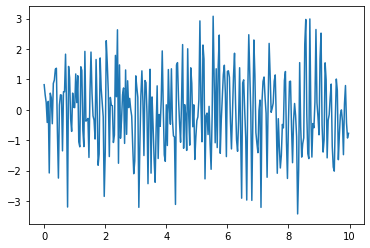

In [77]:
sampling_rate = 30.0
time = np.arange(0, 10, 1/sampling_rate)
data = np.sin(2*np.pi*6*time) + np.random.randn(len(time))
plt.plot(time, data)

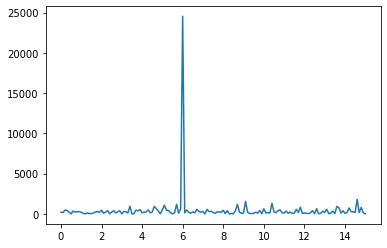

In [17]:
fourier_transform = np.fft.rfft(data)
abs_fourier_transform = np.abs(fourier_transform)
power_spectrum = (abs_fourier_transform)**2
frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))
plt.plot(frequency, power_spectrum)

In [91]:
def numpy_correlate_unnormalized(array, cor_time=None):
    time = len(array)
    if cor_time is None:
        cor_time=time-1
    assert (cor_time < time), "Make sure cor_time is less than length of your input array minus one"
    assert type(array) is np.ndarray,"Your code broke because of wrong inputs"
    c_t = np.correlate(array,array,mode='full')
    half = c_t.size//2
    c_t = c_t[half:half+cor_time+1] # half+max_time_for_corr_function+1] # what is nt ?
    c_t = c_t / np.linspace(time, time-cor_time, cor_time+1, dtype=np.float_) # Time normalization factor
    
    #c_t = c_t / np.linspace(nstep,nstep-nt,nt+1,dtype=np.float_) # nstep = np.linspace(len(array), len(array)-cor_time, cor_time+1, dtype=np.float_)
    return c_t # Returning un-normalized version

In [92]:
cor = numpy_correlate_unnormalized(data)

In [93]:
ft_cor = np.fft.rfft((cor))

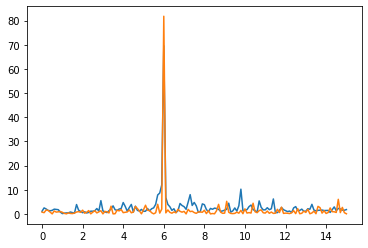

In [98]:
plt.plot(frequency, np.abs(ft_cor))
plt.plot(frequency, power_spectrum/300)

In [30]:
ct = np.fft.irfft(power_spectrum)

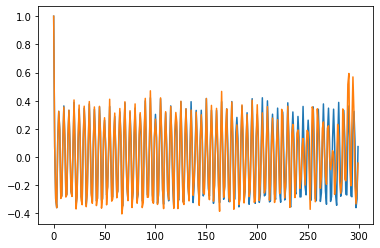

In [80]:
plt.plot(np.arange(len(ct)), ct/ct[0]) # This is through WK thm
plt.plot(np.arange(len(cor)), cor/cor[0]) # Direct 

In [39]:
def mirror(arr, axis=0):
    """Mirror array `arr` at index 0 along `axis`.
    The length of the returned array is 2*arr.shape[axis]-1 ."""
    return np.concatenate((arr[::-1],arr[1:]), axis=axis)

In [89]:
70*300

21000

In [101]:
len(data)

300